# **Natural Language Processing With Disaster Tweets**

# **1. Data Overview**

### **1.1. Meta Data**
- **id**: A unique identifier for each tweet.
- **text**: The text content of the tweet.
- **location**: The location from which the tweet was sent (this field may be blank).
- **keyword**: A specific keyword found in the tweet (this field may be blank).
- **target**: This attribute is present only in `train.csv`. It indicates whether a tweet is about a real disaster (1) or not (0).

### **1.2. What am I predicting?**
You are predicting whether a given tweet is about a real disaster or not. If so, predict a **1**. If not, predict a **0**.

### **1.3. Importing Libararies**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk
import spacy
import scipy.sparse
from tqdm import tqdm
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder, StandardScaler

2024-08-08 14:51:58.919603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 14:51:58.919758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 14:51:59.094731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **1.4. Reading data and header view**

In [2]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **1.5. Shape of Data**

In [3]:
df.shape

(7613, 5)

### **1.6. Description of Data**

In [4]:
df.describe(include='all').round(2).style.format(precision=2).background_gradient(cmap="Reds")

,id,keyword,location,text,target
count,7613.00,7552,5080,7613,7613.00
unique,nan,221,3341,7503,nan
top,nan,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,nan
freq,nan,45,104,10,nan
mean,5441.93,nan,nan,nan,0.43
std,3137.12,nan,nan,nan,0.50
min,1.00,nan,nan,nan,0.00
25%,2734.00,nan,nan,nan,0.00
50%,5408.00,nan,nan,nan,0.00
75%,8146.00,nan,nan,nan,1.00


### **1.7. Info about data**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### **1.8. Null values in Data**

In [6]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### **1.9. Value Counts of Location**

In [7]:
df['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

### **1.10. Value Counts of Keyword**

In [8]:
df['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

### **1.11. Checking Duplicates**

In [9]:
df.duplicated().sum()

0

### **1.12. Checking Data Types**

In [10]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

# **2. Exploratory Data Analysis**

### **2.1. Histogram of Numerical Columns**

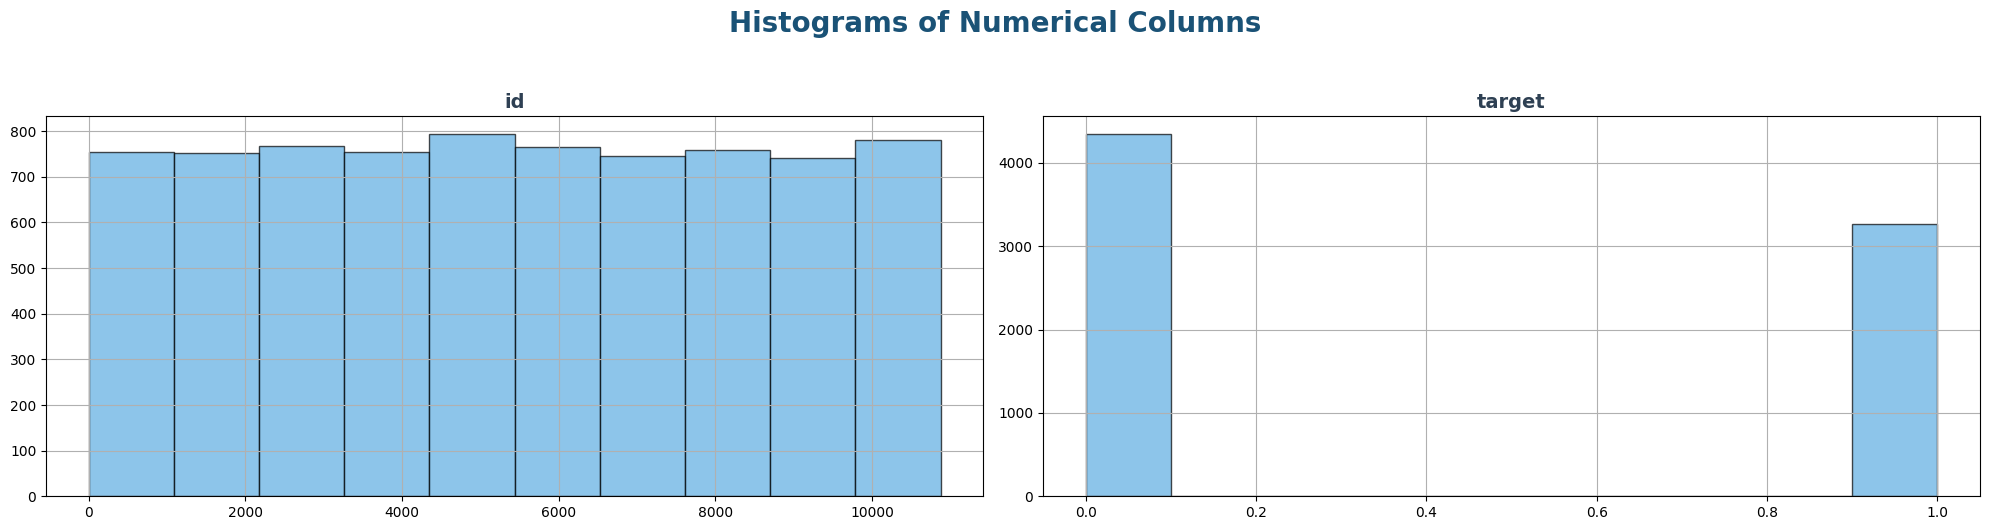

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=len(df.select_dtypes(include='number').columns), figsize=(20, 5), tight_layout=True)

for i, col in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i]
    df[col].hist(ax=ax, color='#5DADE2', edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=14, fontweight='bold', color='#2E4053')
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Histograms of Numerical Columns', fontsize=20, fontweight='bold', color='#1A5276', y=1.05)
plt.subplots_adjust(top=0.85)
plt.show()

### **2.2. Boxplot of Numerical Columns**

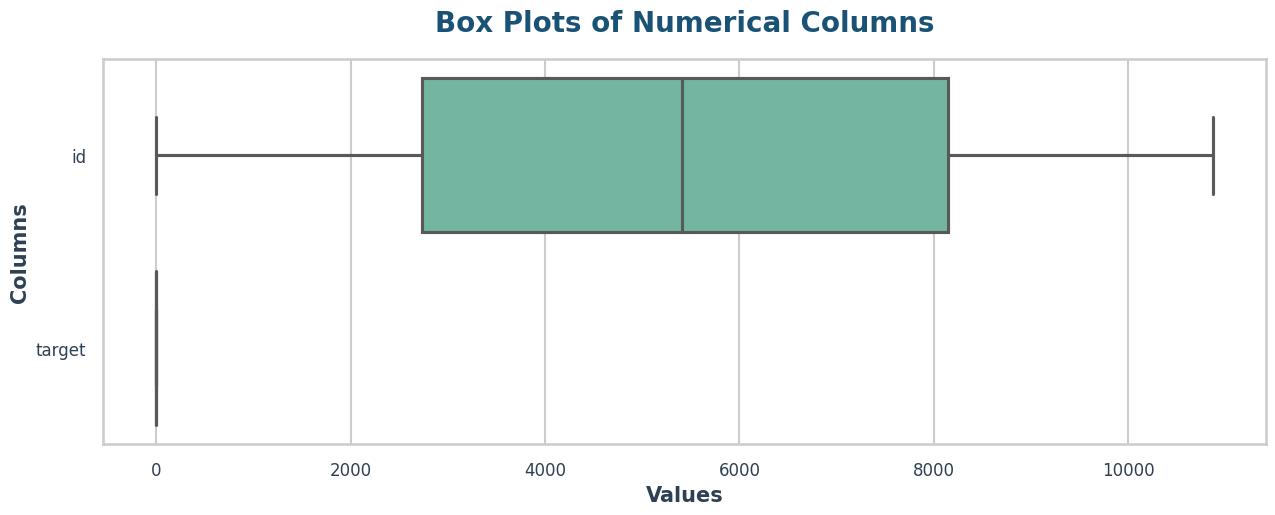

In [12]:
sns.set_style('whitegrid')
sns.set_context('talk')

plt.figure(figsize=(15, 5))
ax = sns.boxplot(data=df, orient='h', palette='Set2')

plt.title('Box Plots of Numerical Columns', fontsize=20, fontweight='bold', color='#1A5276', pad=20)
plt.xlabel('Values', fontsize=15, fontweight='bold', color='#2E4053')
plt.ylabel('Columns', fontsize=15, fontweight='bold', color='#2E4053')

ax.tick_params(axis='x', colors='#2E4053', labelsize=12)
ax.tick_params(axis='y', colors='#2E4053', labelsize=12)

for patch in ax.artists:
    patch.set_edgecolor('#1A5276')
    patch.set_linewidth(2)

plt.show()

### **2.3. Heatmap for MCAR(Missing Completely At Random)**

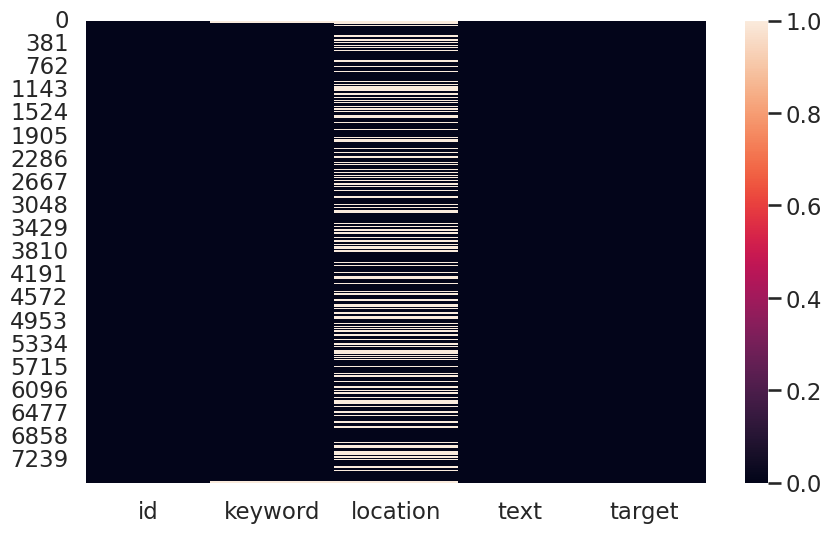

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull())
plt.show()

# **3. Feature Engineering**

### **3.1. Imputing Null Values**

In [14]:
df['keyword'] = df['keyword'].fillna(df['keyword'].mode()[0])
df['location'] = df['location'].fillna(value='Missing')

In [15]:
df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

### **3.2. Dropping "id" irrelevant feature**

In [16]:
df.drop(columns=['id'], inplace=True)

In [17]:
df.head(5)

,keyword,location,text,target
0,fatalities,Missing,Our Deeds are the Reason of this #earthquake M...,1
1,fatalities,Missing,Forest fire near La Ronge Sask. Canada,1
2,fatalities,Missing,All residents asked to 'shelter in place' are ...,1
3,fatalities,Missing,"13,000 people receive #wildfires evacuation or...",1
4,fatalities,Missing,Just got sent this photo from Ruby #Alaska as ...,1


### **3.3. Encoding "Keyword" and "Location" columns**

In [18]:
le = LabelEncoder()

In [19]:
df['keyword'] = le.fit_transform(df['keyword'])
df['location'] = le.fit_transform(df['location'])

In [20]:
df.head(5)

,keyword,location,text,target
0,104,1690,Our Deeds are the Reason of this #earthquake M...,1
1,104,1690,Forest fire near La Ronge Sask. Canada,1
2,104,1690,All residents asked to 'shelter in place' are ...,1
3,104,1690,"13,000 people receive #wildfires evacuation or...",1
4,104,1690,Just got sent this photo from Ruby #Alaska as ...,1


# **4. NLP on text column**

### **4.1. Lowercasing**

In [21]:
df['text'] = df['text'].str.lower()

In [22]:
pd.DataFrame(df['text'].head(5))

,text
0,our deeds are the reason of this #earthquake m...
1,forest fire near la ronge sask. canada
2,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,just got sent this photo from ruby #alaska as ...


### **4.2. Removing html tags**

In [23]:
def remove_html_tags(text):
    clean_text = re.sub('<.*?>', '', text)
    return clean_text

In [24]:
df['text'] = df['text'].apply(remove_html_tags)

In [25]:
pd.DataFrame(df['text'].head(5))

,text
0,our deeds are the reason of this #earthquake m...
1,forest fire near la ronge sask. canada
2,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,just got sent this photo from ruby #alaska as ...


### **4.3. Removing URL's**

In [26]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    clean_text = re.sub(url_pattern, '', text)
    return clean_text

In [27]:
df['text'] = df['text'].apply(remove_urls)

In [28]:
pd.DataFrame(df['text'].head(5))

,text
0,our deeds are the reason of this #earthquake m...
1,forest fire near la ronge sask. canada
2,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,just got sent this photo from ruby #alaska as ...


### **4.4. Removing Punctuations**

In [29]:
def remove_punctuation(text):
    punctuation = string.punctuation
    clean_text = text.translate(str.maketrans('', '', punctuation))
    return clean_text

In [30]:
df['text'] = df['text'].apply(remove_punctuation)

In [31]:
pd.DataFrame(df['text'].head(5))

,text
0,our deeds are the reason of this earthquake ma...
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...
3,13000 people receive wildfires evacuation orde...
4,just got sent this photo from ruby alaska as s...


### **4.5. Chat Word Treatment**

In [32]:
chat_words_mapping = {
    "lol": "laughing out loud",
    "brb": "be right back",
    "btw": "by the way",
    "afk": "away from keyboard",
    "rofl": "rolling on the floor laughing",
    "ttyl": "talk to you later",
    "np": "no problem",
    "thx": "thanks",
    "omg": "oh my god",
    "idk": "I don't know",
    "np": "no problem",
    "gg": "good game",
    "g2g": "got to go",
    "b4": "before",
    "cu": "see you",
    "yw": "you're welcome",
    "wtf": "what the f*ck",
    "imho": "in my humble opinion",
    "jk": "just kidding",
    "gf": "girlfriend",
    "bf": "boyfriend",
    "u": "you",
    "r": "are",
    "2": "to",
    "4": "for",
    "b": "be",
    "c": "see",
    "y": "why",
    "tho": "though",
    "smh": "shaking my head",
    "lolz": "laughing out loud",
    "h8": "hate",
    "luv": "love",
    "pls": "please",
    "sry": "sorry",
    "tbh": "to be honest",
    "omw": "on my way",
    "omw2syg": "on my way to see your girlfriend",
}

def expand_chat_words(text):
    words = text.split()
    expanded_words = [chat_words_mapping.get(word.lower(), word) for word in words]
    return ' '.join(expanded_words)

In [33]:
df['text'] = df['text'].apply(expand_chat_words)

In [34]:
pd.DataFrame(df['text'].head(5))

,text
0,our deeds are the reason of this earthquake ma...
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...
3,13000 people receive wildfires evacuation orde...
4,just got sent this photo from ruby alaska as s...


### **4.6. Removing Stop Words**

In [35]:
def remove_stop_words(text):
	tokens = nltk.word_tokenize(text)
	stop_words = set(stopwords.words('english'))
	filtered_tokens = [token for token in tokens if token not in stop_words]
	preprocessed_text = ' '.join(filtered_tokens)
	return preprocessed_text

In [36]:
df['text'] = df['text'].apply(remove_stop_words)

In [37]:
pd.DataFrame(df['text'].head(5))

,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked shelter place notified officer...
3,13000 people receive wildfires evacuation orde...
4,got sent photo ruby alaska smoke wildfires pou...


### **4.7. Replacing emojis with meanings**

In [38]:
def replace_emojis_with_meanings(text):
    def replace(match):
        emoji_char = match.group()
        emoji_meaning = emoji.demojize(emoji_char)
        return emoji_meaning

    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"
                            u"\U0001F300-\U0001F5FF"
                            u"\U0001F680-\U0001F6FF"
                            u"\U0001F1E0-\U0001F1FF"
                            u"\U00002500-\U00002BEF"
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"
                            u"\u3030"
                            "]+", flags=re.UNICODE)
    text_with_meanings = emoji_pattern.sub(replace, text)
    return text_with_meanings

In [39]:
df['text'] = df['text'].apply(replace_emojis_with_meanings)

In [40]:
pd.DataFrame(df['text'].head(5))

,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked shelter place notified officer...
3,13000 people receive wildfires evacuation orde...
4,got sent photo ruby alaska smoke wildfires pou...


### **4.8. Word Tokenization**

In [41]:
def word_tokenization(text):
    return nltk.word_tokenize(text)

In [42]:
df['token_text'] = df['text'].apply(word_tokenization)

In [43]:
pd.DataFrame(df['text'].head(5))

,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked shelter place notified officer...
3,13000 people receive wildfires evacuation orde...
4,got sent photo ruby alaska smoke wildfires pou...


### **4.9. POS Tagging**

In [44]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'])

def batch_pos_tagging(texts):
    docs = list(nlp.pipe(texts, batch_size=50))
    return [[(token.text, token.pos_) for token in doc] for doc in docs]

batch_size = 50
num_batches = (len(df) + batch_size - 1) // batch_size

pos_tags = []
for i in tqdm(range(num_batches)):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(df))
    batch_texts = df['text'][start:end].tolist()
    pos_tags.extend(batch_pos_tagging(batch_texts))

df['POS_Tags'] = pos_tags

100%|██████████| 153/153 [00:13<00:00, 11.62it/s]


In [45]:
df.head()

,keyword,location,text,target,token_text,POS_Tags
0,104,1690,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, VERB), (reason, NOUN), (earthquake, N..."
1,104,1690,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[(forest, NOUN), (fire, NOUN), (near, ADP), (l..."
2,104,1690,residents asked shelter place notified officer...,1,"[residents, asked, shelter, place, notified, o...","[(residents, NOUN), (asked, VERB), (shelter, N..."
3,104,1690,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation...","[(13000, NUM), (people, NOUN), (receive, VERB)..."
4,104,1690,got sent photo ruby alaska smoke wildfires pou...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, AUX), (sent, VERB), (photo, NOUN), (rub..."


In [46]:
df['token_text'] = df['token_text'].apply(lambda x: ' '.join(x))
df['POS_Tags'] = df['POS_Tags'].apply(lambda x: ' '.join([i[1] for i in x]))

In [47]:
df.head()

,keyword,location,text,target,token_text,POS_Tags
0,104,1690,deeds reason earthquake may allah forgive us,1,deeds reason earthquake may allah forgive us,VERB NOUN NOUN AUX PROPN VERB PRON
1,104,1690,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada,NOUN NOUN ADP PRON PROPN PROPN PROPN
2,104,1690,residents asked shelter place notified officer...,1,residents asked shelter place notified officer...,NOUN VERB NOUN NOUN VERB NOUN NOUN NOUN NOUN N...
3,104,1690,13000 people receive wildfires evacuation orde...,1,13000 people receive wildfires evacuation orde...,NUM NOUN VERB NOUN NOUN NOUN PROPN
4,104,1690,got sent photo ruby alaska smoke wildfires pou...,1,got sent photo ruby alaska smoke wildfires pou...,AUX VERB NOUN PROPN PROPN NOUN VERB VERB NOUN


# **5. Modeling**

### **5.1. Transformation**

In [48]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X['text'].apply(len))

class NumHashtagsExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')])))

class NumMentionsExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')])))

### **5.2. Train Test Split**

In [49]:
X = df[['text']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **5.3. Creating Pipeline for model**

In [50]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', FunctionTransformer(lambda x: x['text'], validate=False)),
            ('tfidf', TfidfVectorizer(max_features=10000))
        ])),
        ('text_length', Pipeline([
            ('selector', FunctionTransformer(lambda x: x, validate=False)),
            ('extract', TextLengthExtractor())
        ])),
        ('num_hashtags', Pipeline([
            ('selector', FunctionTransformer(lambda x: x, validate=False)),
            ('extract', NumHashtagsExtractor())
        ])),
        ('num_mentions', Pipeline([
            ('selector', FunctionTransformer(lambda x: x, validate=False)),
            ('extract', NumMentionsExtractor())
        ]))
    ])),
    ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
])

In [51]:
param_grid = {
    'features__text__tfidf__max_features': [5000, 10000],
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.1, 0.01]
}

### **5.4. Applying Model**

In [52]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7c0d189b2830>)),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(max_features=10000))])),
                                                                       ('text_length',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7c0d189b2950>)),
                                                                                        ('extract',...
                                                                                         NumHashtagsExtractor())])),
                                                                       ('num_mentions',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7c0d189b2a70>)),
                                                                                        ('extract',
                                                                                         NumMentionsExtractor())]))])),
                                       ('clf', GradientBoostingClassifier())]),
             n_jobs=1,
             param_grid={'clf__learning_rate': [0.1, 0.01],
                         'clf__n_estimators': [100, 200],
                         'features__text__tfidf__max_features': [5000, 10000]},
             scoring='f1')

### **5.5. Getting Predictions on Test Data**

In [53]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       874
           1       0.82      0.57      0.67       649

    accuracy                           0.76      1523
   macro avg       0.78      0.74      0.74      1523
weighted avg       0.77      0.76      0.75      1523



# **6. Submission**

In [54]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [55]:
test_X = test_df[['text']]

In [56]:
y_pred_submission = best_model.predict(test_X)

In [57]:
submission_df = pd.DataFrame({'id': test_df['id'], 'target': y_pred_submission})
submission_df.to_csv('submission.csv', index=False)

## **Thank You So Much**